# Machine Learning Workflow

Building Machine Learning models is essentially a trial-and-error process that involves testing and comparing a large combination of inputs.  

Let's use the **MNIST** dataset as an example.

In [2]:
# load data
from sklearn import datasets
digits = datasets.load_digits(n_class=10, return_X_y=False)
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [3]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

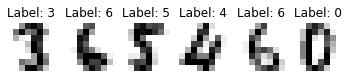

In [4]:
# visualize some examples
import random
random.seed(10)

import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 6)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[:], random.sample(images_and_labels, 6)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % label)

Our goal is to build a classification model to classify the handwritten digits correctly.  We might ask ourselves the following questions:

1. **Type of model** - SVM, Decision Trees, or NN?  Linear or non-linear?
2. **Data preprocessing** - do we need to reshape our images?  Should we standardize images?
3. **Model selection** - Kfold, shufflesplit, stratified split?
4. **Evaluation** - which metrics to use? 
5. **Visualization** - what kind of plot?



[Image reference](https://towardsdatascience.com/a-6-step-field-guide-for-building-machine-learning-projects-6e4554f6e3a1)

Adding in hyperparameter tuning, that's a *lot* of combinations!   



## `pydra` for Machine Learning 

**As you go along, it can be hard to keep track of which score, plot or output is associated which set of parameters.**

Hyperparameter tuning is an important step in developing machine learning models.  
XXX You learned how to run multiple tasks within a pipeline with *pydra* `Workflow` in the `intro_workflow` tutorial.  

In [5]:
import pydra

import matplotlib.pyplot as plt
import sklearn
import typing as ty

A newer version (0.5) of nipype/pydra is available. You are using 0.4+59.geab0897.dirty


### Case #1 - Hyperparameter tuning


Say you want to see the affect of different training sizes, kernel, gamma and regularization have on the accuracy of a SVM model.  To keep track of these models, you can use `pydra` to make a `Workflow` with two tasks:

1. Load and split data with `train_test_split` splitting on `train_size`
2. Fit a SVM with `SVC` splitting on `kernel`, `gamma` and `C`, then calculate accuracy

First we define the tasks...

In [6]:
# splitting data
from sklearn.model_selection import train_test_split

@pydra.mark.task
@pydra.mark.annotate({"return": {'X_tr': ty.Any, 'X_tt': ty.Any,
                                 'y_tr': ty.Any, 'y_tt': ty.Any}})
def simple_split(train_size, random_state=0):
    
    X, y = datasets.load_digits(n_class=10, return_X_y=True)
    X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, train_size=train_size, random_state=random_state)
    return(X_tr, X_tt, y_tr, y_tt)

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
# fit a SVM and returns accuracy score
from sklearn.svm import SVC

@pydra.mark.task
@pydra.mark.annotate({"return": {"score": ty.Any}})
def fit_SVM1(X_tr, y_tr, X_tt, y_tt, C=1, kernel='linear', gamma=1):
    from sklearn.svm import SVC
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_tr, y_tr)
    
    from sklearn.metrics import accuracy_score
    y_pred = clf.predict(X_tt)
    return(accuracy_score(y_tt, y_pred))

Then we add them to a workflow...

In [8]:
wf1_inputs = {'train_size': [0.8, 0.5],
              'C': [0.1, 10], 
              'gamma': [1, 0.01], 
              'kernel': ['linear', 'rbf']}

In [9]:
# linear SVM spliting on gamma and C
wf1 = pydra.Workflow(name="svm", 
                     input_spec=list(wf1_inputs.keys()), **wf1_inputs)

wf1.split(['train_size', 'gamma', 'C', 'kernel'])
wf1.add(simple_split(name='split_data', 
                     train_size=wf1.lzin.train_size))  

wf1.add(fit_SVM1(name='fit_clf', 
                 X_tr=wf1.split_data.lzout.X_tr, y_tr=wf1.split_data.lzout.y_tr, 
                 X_tt=wf1.split_data.lzout.X_tt, y_tt=wf1.split_data.lzout.y_tt,
                 kernel=wf1.lzin.kernel, C=wf1.lzin.C, gamma=wf1.lzin.gamma))  

wf1.set_output([("acc_score", wf1.fit_clf.lzout.score)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf1)
    
wf1.result()

[Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False),
 Result(output=Output(acc_score=0.08055555555555556), runtime=None, errored=False),
 Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False),
 Result(output=Output(acc_score=0.08055555555555556), runtime=None, errored=False),
 Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False),
 Result(output=Output(acc_score=0.08055555555555556), runtime=None, errored=False),
 Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False),
 Result(output=Output(acc_score=0.7944444444444444), runtime=None, errored=False),
 Result(output=Output(acc_score=0.967741935483871), runtime=None, errored=False),
 Result(output=Output(acc_score=0.08453837597330367), runtime=None, errored=False),
 Result(output=Output(acc_score=0.967741935483871), runtime=None, errored=False),
 Result(output=Output(acc_score=0.08453837597330367), runtime=None, errored=False),
 

We have our outputs!  Thought it is not clear which output comes from which set of parameters.  

Using the `verbose` option is a good idea here.  It's give you a list of tuples that contain a dictionary of input parameters and the result.

In [11]:
# Better way to display results?  Return a table or just a dictionary?
wf1.result(return_inputs=True)

[({'svm.train_size': 0.8,
   'svm.gamma': 1,
   'svm.C': 0.1,
   'svm.kernel': 'linear'},
  Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False)),
 ({'svm.train_size': 0.8, 'svm.gamma': 1, 'svm.C': 0.1, 'svm.kernel': 'rbf'},
  Result(output=Output(acc_score=0.08055555555555556), runtime=None, errored=False)),
 ({'svm.train_size': 0.8, 'svm.gamma': 1, 'svm.C': 10, 'svm.kernel': 'linear'},
  Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False)),
 ({'svm.train_size': 0.8, 'svm.gamma': 1, 'svm.C': 10, 'svm.kernel': 'rbf'},
  Result(output=Output(acc_score=0.08055555555555556), runtime=None, errored=False)),
 ({'svm.train_size': 0.8,
   'svm.gamma': 0.01,
   'svm.C': 0.1,
   'svm.kernel': 'linear'},
  Result(output=Output(acc_score=0.9777777777777777), runtime=None, errored=False)),
 ({'svm.train_size': 0.8,
   'svm.gamma': 0.01,
   'svm.C': 0.1,
   'svm.kernel': 'rbf'},
  Result(output=Output(acc_score=0.08055555555555556), runtime=No

### Case #2 - Comparing different metrics


Say in addition to accuracy, you also want to look at `f1_score` and `confusion_matrix` of the models in `wf1`.  You also want all the metrics for a model in one workflow result.

So you can now modify it into a 3-task workflow:

1. Load and split data with `train_test_split`, splitting on `train_size` 
2. Fit a SVM with `SVC` splitting on `kernel`, `gamma` and `C` 
3. Calculate different metrics, splitting on the `metric` variable

In [12]:
# fit_SVM2 - fits a SVM then returns a trained model
@pydra.mark.task
@pydra.mark.annotate({"return": {"clf": ty.Any}})
def fit_SVM2(X_tr, y_tr, C=1, kernel='linear', gamma=1):
    from sklearn.svm import SVC
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_tr, y_tr)
    return(clf)

In [13]:
# metric_score - calculate metrics
@pydra.mark.task
@pydra.mark.annotate({"return": {"metric": ty.Any}})
def metric_score(clf, X_tt, y_tt, method):
    
    y_pred = clf.predict(X_tt)
    
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
    if method == 'acc':
        metric = accuracy_score(y_tt, y_pred)
    elif method == 'f1':
        metric = f1_score(y_tt, y_pred, average='macro')
    else:
        metric = confusion_matrix(y_tt, y_pred)
    return(metric)

In [14]:
wf2_inputs = {'train_size': [0.5, 0.8],
              'C': [0.1, 10,], 
              'gamma': [1, 0.01], 
              'kernel': ['linear', 'rbf'],
              'metric': ['acc', 'f1']}

In [15]:
wf2_inputs = {'train_size': [0.5, 0.8],
              'C': [0.1, 10,], 
              'gamma': [1, 0.01], 
              'kernel': ['linear', 'rbf'],
              'metric': ['acc', 'f1']}

# Working!
# SVM splitting all. vars on workflow level
wf2 = pydra.Workflow(name="svm2", 
                     input_spec=list(wf2_inputs.keys()), **wf2_inputs)

# Workflow-level splits
wf2.split(['train_size', 'kernel', 'gamma', 'C', 'metric'])
wf2.add(simple_split(name='split_data', 
                     train_size=wf2.lzin.train_size))  

wf2.add(fit_SVM2(name='fit_clf', 
                X_tr=wf2.split_data.lzout.X_tr, y_tr=wf2.split_data.lzout.y_tr, 
                kernel=wf2.lzin.kernel, C=wf2.lzin.C, gamma=wf2.lzin.gamma))  

wf2.add(metric_score(name='calc_metric', 
                     clf=wf2.fit_clf.lzout.clf,
                     X_tt=wf2.split_data.lzout.X_tt, y_tt=wf2.split_data.lzout.y_tt,
                     method=wf2.lzin.metric))  

wf2.set_output([("metrics", wf2.calc_metric.lzout.metric)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)
    
wf2.result(return_inputs=True)

[({'svm2.train_size': 0.5,
   'svm2.kernel': 'linear',
   'svm2.gamma': 1,
   'svm2.C': 0.1,
   'svm2.metric': 'acc'},
  Result(output=Output(metrics=0.967741935483871), runtime=None, errored=False)),
 ({'svm2.train_size': 0.5,
   'svm2.kernel': 'linear',
   'svm2.gamma': 1,
   'svm2.C': 0.1,
   'svm2.metric': 'f1'},
  Result(output=Output(metrics=0.9686848947655866), runtime=None, errored=False)),
 ({'svm2.train_size': 0.5,
   'svm2.kernel': 'linear',
   'svm2.gamma': 1,
   'svm2.C': 10,
   'svm2.metric': 'acc'},
  Result(output=Output(metrics=0.967741935483871), runtime=None, errored=False)),
 ({'svm2.train_size': 0.5,
   'svm2.kernel': 'linear',
   'svm2.gamma': 1,
   'svm2.C': 10,
   'svm2.metric': 'f1'},
  Result(output=Output(metrics=0.9686848947655866), runtime=None, errored=False)),
 ({'svm2.train_size': 0.5,
   'svm2.kernel': 'linear',
   'svm2.gamma': 0.01,
   'svm2.C': 0.1,
   'svm2.metric': 'acc'},
  Result(output=Output(metrics=0.967741935483871), runtime=None, errored=Fal

In [16]:
# Should verbose=True have a output with a different output when things are combined?
wf2.combine(['train_size', 'kernel'])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)

wf2.result(return_inputs=True)

[[({'svm2.train_size': 0.5,
    'svm2.kernel': 'linear',
    'svm2.gamma': 1,
    'svm2.C': 0.1,
    'svm2.metric': 'acc'},
   Result(output=Output(metrics=0.967741935483871), runtime=None, errored=False)),
  ({'svm2.train_size': 0.5,
    'svm2.kernel': 'rbf',
    'svm2.gamma': 1,
    'svm2.C': 0.1,
    'svm2.metric': 'acc'},
   Result(output=Output(metrics=0.08453837597330367), runtime=None, errored=False)),
  ({'svm2.train_size': 0.8,
    'svm2.kernel': 'linear',
    'svm2.gamma': 1,
    'svm2.C': 0.1,
    'svm2.metric': 'acc'},
   Result(output=Output(metrics=0.9777777777777777), runtime=None, errored=False)),
  ({'svm2.train_size': 0.8,
    'svm2.kernel': 'rbf',
    'svm2.gamma': 1,
    'svm2.C': 0.1,
    'svm2.metric': 'acc'},
   Result(output=Output(metrics=0.08055555555555556), runtime=None, errored=False))],
 [({'svm2.train_size': 0.5,
    'svm2.kernel': 'linear',
    'svm2.gamma': 1,
    'svm2.C': 0.1,
    'svm2.metric': 'f1'},
   Result(output=Output(metrics=0.968684894765586

In [ ]:
with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)

wf2_split32 = wf2.result(verbose=True)
len(wf2_split32)

# Test code

In [17]:
# NOT working!
# SVM with metric=confusion
# ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

wf2_inputs = {'train_size': [0.5, 0.8],
              'C': [0.1, 10,], 
              'gamma': [1, 0.01], 
              'kernel': ['linear', 'rbf'],
              'metric': ['confusion']}

wf2 = pydra.Workflow(name="svm2", 
                     input_spec=list(wf2_inputs.keys()), **wf2_inputs)

wf2.split(['train_size', 'kernel', 'gamma', 'C', 'metric'])
wf2.add(simple_split(name='split_data', 
                     train_size=wf2.lzin.train_size))  

wf2.add(fit_SVM2(name='fit_clf', 
                X_tr=wf2.split_data.lzout.X_tr, y_tr=wf2.split_data.lzout.y_tr, 
                kernel=wf2.lzin.kernel, C=wf2.lzin.C, gamma=wf2.lzin.gamma))  

wf2.add(metric_score(name='calc_metric', 
                     clf=wf2.fit_clf.lzout.clf,
                     X_tt=wf2.split_data.lzout.X_tt, y_tt=wf2.split_data.lzout.y_tt,
                     method=wf2.lzin.metric))  

wf2.set_output([("metric", wf2.calc_metric.lzout.metric)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)
    
wf2.result(return_inputs=True)

exception calling callback for <Future at 0x1218d4b10 state=finished returned Result>
Traceback (most recent call last):
  File "/Users/gablab/anaconda3/envs/pydra/lib/python3.7/concurrent/futures/_base.py", line 324, in _invoke_callbacks
    callback(self)
  File "/Users/gablab/anaconda3/envs/pydra/lib/python3.7/asyncio/futures.py", line 365, in _call_set_state
    dest_loop.call_soon_threadsafe(_set_state, destination, source)
  File "/Users/gablab/anaconda3/envs/pydra/lib/python3.7/asyncio/base_events.py", line 732, in call_soon_threadsafe
    self._check_closed()
  File "/Users/gablab/anaconda3/envs/pydra/lib/python3.7/asyncio/base_events.py", line 479, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [163]:
# Testing confusion matrix
X, y = datasets.load_digits(n_class=10, return_X_y=True)
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, train_size=0.5, random_state=0)

clf = SVC(kernel='linear', gamma=1, C=10)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_tt)
#sklearn.metrics.precision_score(y_tt, y_pred, average='macro')
sklearn.metrics.confusion_matrix(y_tt, y_pred)

array([[ 89,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  86,   0,   0,   0,   1,   1,   0,   2,   0],
       [  0,   1,  91,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  92,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  76,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0, 104,   1,   0,   0,   2],
       [  0,   1,   0,   0,   0,   0,  88,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  77,   1,   0],
       [  0,   2,   1,   1,   1,   3,   0,   1,  81,   2],
       [  0,   0,   0,   2,   0,   3,   0,   0,   1,  86]])

In [162]:
from sklearn.model_selection import ShuffleSplit
gss = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_test_splits = list(gss.split(X, y))
#train_test_splits